# Typeform: ML Case (1): Pandas and SciKit Learn Regression models


Create a model to predict the completion rate (defined as submissions/views ) of a form given the features in the dataset.

- Dataset (> 10000 samples) csv file with form_id,submissions,view,features as “-” separated.
- Delivery API and Github repo
- The model with the code and data in the repo and the README file.

Sketch architecture:
- Pipeline running in aws
- Predictions delivered as API call (should be apro 15000 call for minute)
- A robust monitoring and update system for the model.

Please describe briefly each stage - choice of tech at relevant stages of the pipeline.
Please point if any weak points of the choices you have made.

1. Using Python pandas and scypy and SciKit Learn.
2. Use Spark to solve the exercise.
3. Use a simple - not too DNN to solve the exercise (Not to worry about overfitting)

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [4]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Typeform: Machine Learning Case

- Reading the dataframe
- Data cleaning and calculating completion_rate
- Exploratory analysis
- Feature selection
- Model fitting: Linear Regression, Random Forest Regressor
- Model evaluation MAE
- Building sklearn pipelines to retrain and predict

### Typeform: Reading the dataframe

In [5]:
df_typeform = pd.read_csv("./data/typeform.csv", header=None)
df_typeform.columns = ["form_id", "submissions", "view", "features"]
df_typeform.head()

,form_id,submissions,view,features
0,(1113027,33,27,0.0-0.0-0.0-0.0-0.0-0.0-1.0-0.0-1.0-0.0-0.0-0....
1,(1115313,147,111,0.0-2.0-0.0-0.0-0.0-0.0-0.0-0.0-1.0-0.0-0.0-0....
2,(1115907,528,136,0.0-1.0-0.0-0.0-1.0-0.0-6.0-0.0-1.0-0.0-0.0-0....
3,(1116299,55,21,0.0-2.0-0.0-0.0-0.0-1.0-2.0-0.0-2.0-0.0-0.0-0....
4,(1120373,62,54,0.0-0.0-0.0-0.0-1.0-0.0-4.0-0.0-0.0-0.0-0.0-0....


In [6]:
df_typeform.shape

(1031284, 4)

### Typeform: Data cleaning and calculating completion_rate

- Cleaning form_id's, becase we are not going to use them in our models.
- Unstacking features into single columns (needed to build the resulting dataframe)
- Checking for missing data and converting to float

**Cleaning form_id's, althoug we are not going to use them**

In [7]:
df_typeform['form_id'] = \
    df_typeform.form_id.apply(lambda x : x[1:] if x[0] == '(' else x)

**Unstacking features into single columns, one feature one column**

In [8]:
df_typeform['features'] = \
    df_typeform.features.apply(lambda x : x.split('-'))

In [9]:
# checking if the feature length is the same or there
# are observations with missing features
df_typeform['features'].apply(lambda x : len(x)).unique()

array([47])

In [10]:
features = df_typeform.features.apply(pd.Series)
features = features.rename(columns = lambda x : 'feature_' + str(x))

In [11]:
features['feature_46'] = features['feature_46'].apply(lambda x : x[:-1])

In [12]:
df_typeform = pd.concat([df_typeform[["form_id", "submissions", "view"]], features[:]], axis=1)
df_typeform.head()

,form_id,submissions,view,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46
0,1113027,33,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,1115313,147,111,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1115907,528,136,0.0,1.0,0.0,0.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0
3,1116299,55,21,0.0,2.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
4,1120373,62,54,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,11.0,7.0,21.0


**Checking for missing data and converting to float**

In [13]:
pd.DataFrame(df_typeform.isna().sum()).T

,form_id,submissions,view,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_typeform = df_typeform.astype(float)

**Calculating the output variable, completion_rate, as submissions/views**

Droping the observation where views = 0 (so when we divide submissions dosen't result in Inf.)

In [15]:
df_typeform[df_typeform.view == 0]

,form_id,submissions,view,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46
60570,11697806.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [16]:
df_typeform.drop(index=60570, inplace=True)

Calculating completion_rate = submissions / view

In [17]:
df_typeform['completion_rate'] = df_typeform.submissions / df_typeform.view

In [18]:
df_typeform = df_typeform[list(df_typeform.columns[3:])].astype(float).copy()

In [19]:
df_typeform.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,completion_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.222222
1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.324324
2,0.0,1.0,0.0,0.0,1.0,0.0,6.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0,3.882353
3,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,2.619048
4,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,11.0,7.0,21.0,1.148148


In [20]:
df_typeform.to_pickle("./data/df_typeform.pkl")

### Typeform: Exploratory analysis

- Descriptive statistics
- Correlations between features

In [21]:
df_typeform = pd.read_pickle("./data/df_typeform.pkl")

In [22]:
# 47 features and the output variable | 1031283 observations
df_typeform.shape

(1031283, 48)

In [23]:
features = list(df_typeform.columns[:-1])
output = ['completion_rate']

In [24]:
df_typeform.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,1031283.0,0.195451,0.396547,0.0,0.000000,0.000000,0.000000,1.00
feature_1,1031283.0,0.374913,0.933426,0.0,0.000000,0.000000,0.000000,55.00
feature_2,1031283.0,0.054973,0.440342,0.0,0.000000,0.000000,0.000000,78.00
feature_3,1031283.0,0.001025,0.033071,0.0,0.000000,0.000000,0.000000,5.00
feature_4,1031283.0,0.144950,0.480264,0.0,0.000000,0.000000,0.000000,87.00
feature_5,1031283.0,0.176905,0.947294,0.0,0.000000,0.000000,0.000000,96.00
feature_6,1031283.0,0.851396,1.883367,0.0,0.000000,0.000000,1.000000,124.00
feature_7,1031283.0,0.096056,0.310995,0.0,0.000000,0.000000,0.000000,15.00
feature_8,1031283.0,0.660573,1.240156,0.0,0.000000,0.000000,1.000000,165.00
feature_9,1031283.0,0.013566,0.133814,0.0,0.000000,0.000000,0.000000,16.00


- most features are very skweed, and only apply to high percentiles
- feature_0 and feature_19 seem to be binary variables (can be treated as categorical)
- scaling the output could be a good strategy

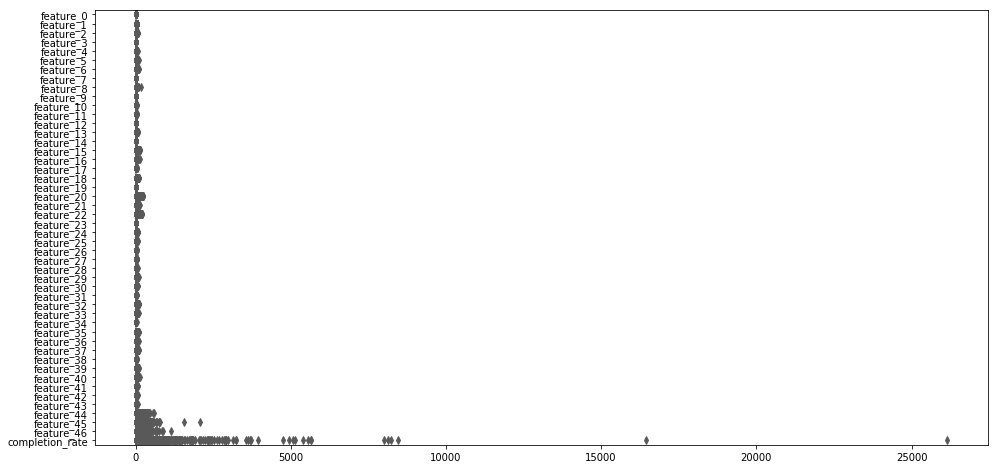

In [25]:
plt.figure(figsize=(16,8))
ax = sns.boxplot(data=df_typeform, orient="h", palette="Set2", showfliers=True)

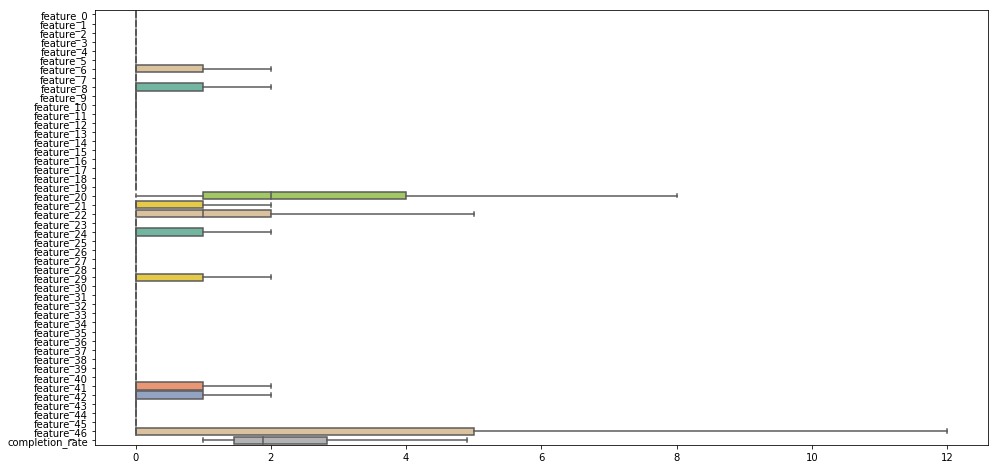

In [26]:
plt.figure(figsize=(16,8))
ax = sns.boxplot(data=df_typeform, orient="h", palette="Set2", showfliers=False)

### Typeform: Feature selection

- Feature scaling (if needed)
- Feature selection: filter based on correlations
- Feature selection: univariate selection
- Feature selection: feature importance
- Feature selection: regression stepwise

In [27]:
X = df_typeform[features].astype('float')
y = df_typeform[output].completion_rate.astype('int')

**Feature scaling**

In [32]:
X_std = StandardScaler().fit_transform(
    df_typeform[features].astype('float'))
y_std = StandardScaler().fit_transform(
    df_typeform[output].astype('float'))

**Feature selection: filter based on correlations**

Find index of feature columns with correlation greater than 0.90

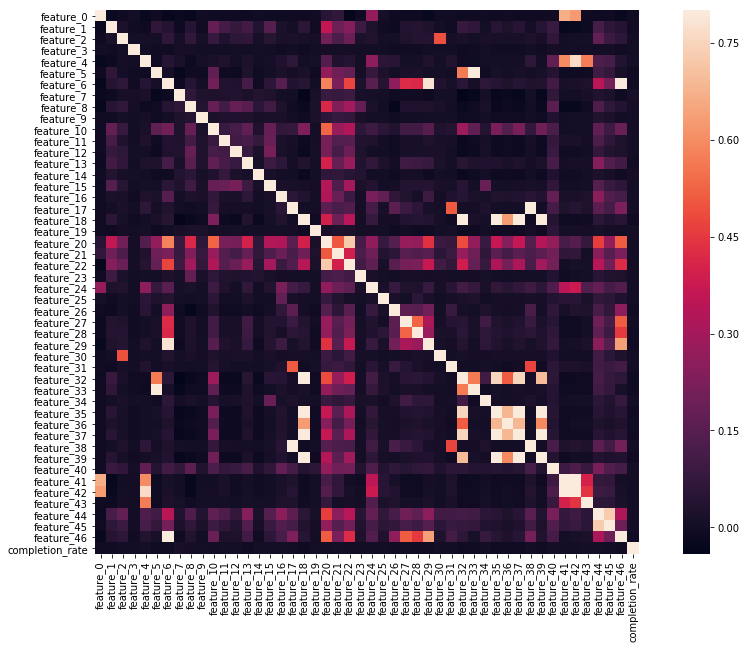

In [33]:
plt.figure(figsize=(16,10))
sns.heatmap(df_typeform.corr(), vmax = .8, square = True)
plt.show()

In [34]:
corr_matrix = df_typeform.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [35]:
to_drop

['feature_32',
 'feature_33',
 'feature_35',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_42',
 'feature_46']

**Feature selection: univariate selection**

In [36]:
model = SelectKBest(score_func=chi2, k=10)
fit = model.fit(X,y.astype(int))
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

         Specs         Score
32  feature_32  50430.026114
46  feature_46  48485.908706
8    feature_8  44346.117337
45  feature_45  36138.257423
18  feature_18  30977.824403
44  feature_44  29868.064431
21  feature_21  24975.629029
37  feature_37  24428.904400
35  feature_35  24404.424426
5    feature_5  23234.039737


**Feature selection: Feature importance embeded method**

In [46]:
df_typeform_sample = df_typeform.sample(n = 10000)

In [55]:
X_sample = df_typeform_sample[features].astype('float')
y_sample = df_typeform_sample[output].completion_rate.astype('int')

In [56]:
model = LassoCV()
model.fit(X_sample, y_sample)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" % model.score(X,y))
coef = pd.Series(model.coef_, index = X_sample.columns)

Best alpha using built-in LassoCV: 0.054163
Best score using built-in LassoCV: 0.000282


In [58]:
print("\nLasso picked " + str(sum(coef != 0)) + \
      " variables and eliminated the other " +  \
      str(sum(coef == 0)) + " variables\n")


Lasso picked 17 variables and eliminated the other 30 variables



Text(0.5, 1.0, 'Feature importance using Lasso Model')

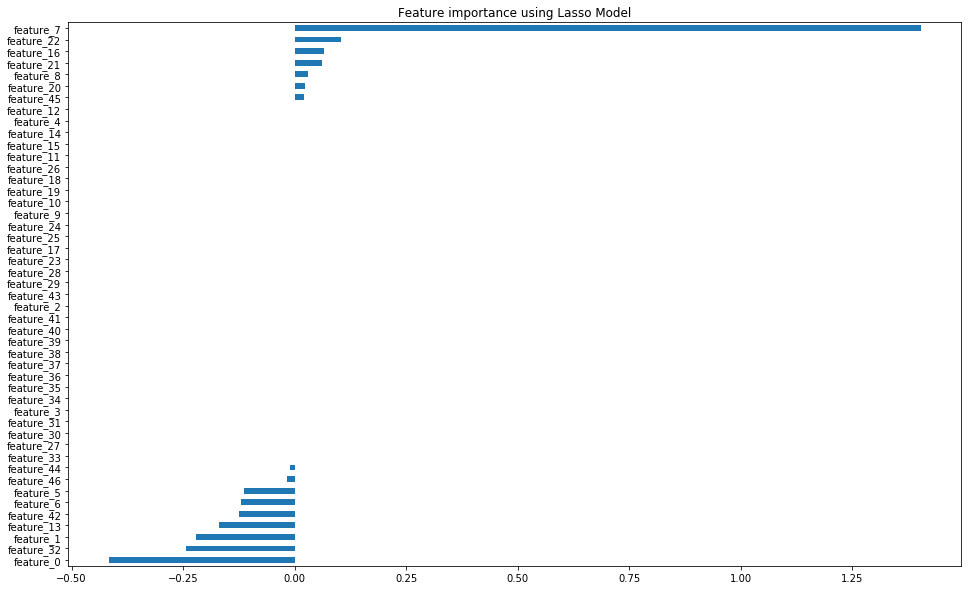

In [59]:
imp_coef = coef.sort_values()
ax = imp_coef.plot(kind = "barh", figsize=(16,10))
ax.set_title("Feature importance using Lasso Model")

**Feature selection: regression stepwise**

In [60]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [61]:
y = df_typeform[['completion_rate']]
X = df_typeform[list(df_typeform.columns[:-1])]

In [62]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=42)

In [63]:
result = stepwise_selection(X_train, y_train)

print('resulting features:')
print(result)

Add  feature_7                      with p-value 1.07961e-18
Add  feature_19                     with p-value 2.24058e-12
Add  feature_32                     with p-value 3.48116e-10
Add  feature_21                     with p-value 1.77738e-06
Add  feature_14                     with p-value 1.4978e-05
Add  feature_13                     with p-value 0.00464293
Add  feature_15                     with p-value 0.00467955
resulting features:
['feature_7', 'feature_19', 'feature_32', 'feature_21', 'feature_14', 'feature_13', 'feature_15']


In [64]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        completion_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     101.5
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:58:23   Log-Likelihood:            -5.3520e+06
No. Observations:             1031283   AIC:                         1.070e+07
Df Residuals:                 1031237   BIC:                         1.070e+07
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
feature_0      2.6209      2.107      1.244      0.213      -1.508       6.750
feature_1      0.7350      0.346      2.122      0.034       0.056       1.414
feature_2      0.5112      0.361      1.416      0.157      -0.196       1.219
feature_3      2.3360      1.337      1.747      0.081      -0.284       4.956
feature_4      1.9069      2.103      0.907      0.365      -2.215       6.028
feature_5      0.0775      0.220      0.352      0.725      -0.354       0.508
feature_6      0.4883      0.348      1.404      0.160      -0.193       1.170
feature_7      3.2773      0.369      8.871      0.000       2.553       4.001
feature_8      0.9839      0.345      2.854      0.004       0.308       1.660
feature_9      1.7596      0.470      3.746      0.000       0.839       2.680
feature_10    -0.1320      0.354     -0.373      0.709      -0.826       0.562
feature_11     0.4775      0.377      1.267      0.205      -0.261       1.216
feature_12     0.2703      0.408      0.663      0.507      -0.528       1.069
feature_13     0.2614      0.348      0.752      0.452      -0.420       0.943
feature_14     2.9016      0.478      6.075      0.000       1.965       3.838
feature_15     0.3535      0.350      1.009      0.313      -0.333       1.040
feature_16     0.7621      0.347      2.195      0.028       0.082       1.442
feature_17     0.4432      0.422      1.050      0.294      -0.384       1.270
feature_18     0.1246      0.446      0.279      0.780      -0.750       0.999
feature_19     8.0826      0.990      8.166      0.000       6.143      10.023
feature_20    -0.2503      0.343     -0.730      0.466      -0.923       0.422
feature_21     0.0788      0.031      2.519      0.012       0.017       0.140
feature_22     0.0979      0.023      4.316      0.000       0.053       0.142
feature_23     0.0006      0.142      0.005      0.996      -0.277       0.279
feature_24    -0.0100      0.050     -0.201      0.841      -0.107       0.087
feature_25    -0.0039      0.187     -0.021      0.983      -0.370       0.362
feature_26    -0.0981      0.084     -1.168      0.243      -0.263       0.067
feature_27     0.2100      0.088      2.394      0.017       0.038       0.382
feature_28     0.0295      0.080      0.367      0.714      -0.128       0.187
feature_29    -0.0336      0.046     -0.728      0.466      -0.124       0.057
feature_30     0.0599      0.245      0.245      0.807      -0.420       0.539
feature_31     0.1333      0.225      0.592      0.554      -0.308       0.575
feature_32     0.1353      0.271      0.499      0.618      -0.396       0.667
feature_33     0.0775      0.220      0.352      0.725      -0.354       0.508
feature_34     0.0779      0.362      0.215      0.830      -0.632       0.788
feature_35    -0.1491      0.714     -0.209      0.835      -1.549       1.250
fe

In [65]:
df_typeform_ = df_typeform[
    ['feature_7','feature_19','feature_32','feature_21','feature_14','feature_13','feature_15','completion_rate']
].copy()

## Typeform: Model fitting

- Splitting intp Training set and Testing set
- Model fitting: LinearRegression, Lasso... RandomForestRegressor

**Splitting intp Training set and Testing set**

In [66]:
X_ = df_typeform_[list(df_typeform_.columns[:-1])]
y_ = df_typeform_[['completion_rate']]

In [67]:
X_train_, X_test_, y_train_, y_test_ = \
    train_test_split(X_, y_, test_size=0.33, random_state=42)

**Model fitting (1): Linear regression**

In [68]:
model_1 = sm.OLS(y_train_, X_train_).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        completion_rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:59:17   Log-Likelihood:            -3.6092e+06
No. Observations:              690959   AIC:                         7.218e+06
Df Residuals:                  690952   BIC:                         7.218e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
feature_7      3.7941      0.169     22.418      0.000       3.462       4.126
feature_19    10.1239      1.182      8.568      0.000       7.808      12.440
feature_32     0.0833      0.032      2.565      0.010       0.020       0.147
feature_21     0.6236      0.034     18.290      0.000       0.557       0.690
feature_14     3.0634      0.416      7.371      0.000       2.249       3.878
feature_13     0.4293      0.066      6.547      0.000       0.301       0.558
feature_15     0.4186      0.083      5.055      0.000       0.256       0.581
===============================================================================
Omnibus:                  3923013.503   Durbin-Watson:                    1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   890313490912940.625
Skew:                         342.687   Prob(JB):                          0.00
Kurtosis:                  175855.141   Cond. No.                          45.8
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
y_pred_1 = model_1.predict(X_test_)

In [70]:
y_test_1 = y_test_.copy()

In [71]:
y_test_1['y_pred'] = y_pred_1
y_test_1.columns = ['y_test','y_pred']
y_test_1['MAE'] = y_test_1.y_test - y_test_1.y_pred
y_test_1['MAE'] = y_test_1.MAE.apply(lambda x : np.absolute(x))

model_1_MAE = y_test_1.MAE.mean()

**Model fitting (2): Random Forest with hyperparameter tunning**

Hyperparameter tunning with Grid search

In [72]:
model_ = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 500, 1000],
}
model_2 = GridSearchCV(model_, parameters, cv=2, verbose=2, n_jobs=-1)

In [73]:
model_2.fit(X_train_, y_train_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.0min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

## Typeform: Model evaluation

We endunp picking the random forest for better MAE

In [74]:
y_pred_1 = model_1.predict(X_test_)

In [75]:
MAE = mean_absolute_error(y_test_, y_pred_1)
print('Linear regression validation MAE = ', MAE)

Linear regression validation MAE =  3.275541339886973


In [76]:
y_pred_2 = model_2.predict(X_test_)

In [77]:
MAE = mean_absolute_error(y_test_ , y_pred_2)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  2.9240913766587613


## Typeform: Saving the best model for prediction


In [78]:
from joblib import dump, load

In [79]:
dump(model_1, './models/model_1_linearReg.joblib') 

['./models/model_1_linearReg.joblib']

In [80]:
dump(model_2, './models/model_2_randomForestReg.joblib') 

['./models/model_2_randomForestReg.joblib']